In [117]:
import scipy.stats as spst
import scipy
import seaborn as sns
import numpy as np
import pandas as pd
import qrbook_funcs as qf
from scipy import stats
from tabulate import tabulate
from arch import arch_model
import math
import statistics 
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
import warnings
warnings.filterwarnings('ignore')

#### Q1. Find two random variable 1) Negative Pearson with positive Spearman correlation. 2) Positive Pearson with negative Spearman correlation

In [119]:
x=[1,1,1,1,100]
y=[100,3,2,2,3]
pearson1=spst.pearsonr(x,y)
spearman1=spst.spearmanr(x,y)
print("First one: negative pearson but positive Spearman")
print("Pearson correlation is: ", pearson1[0])
print("Spearman correlation is: ", spearman1[0])

First one: negative pearson but positive Spearman
Pearson correlation is:  -0.2435737300641969
Spearman correlation is:  0.18633899812498247


In [120]:
xx=np.asarray(x)*(-1)
yy=y
pearson2=spst.pearsonr(xx,yy)
spearman2=spst.spearmanr(xx,yy)
print("Second one: positive pearson but negative Spearman")
print("Pearson correlation is: ", pearson2[0])
print("Spearman correlation is: ", spearman2[0])

Second one: positive pearson but negative Spearman
Pearson correlation is:  0.2435737300641969
Spearman correlation is:  -0.18633899812498247


#### Q2. Compute the average correlation

In [121]:
# read data
data=pd.read_excel('Dow 2013 vol.xlsx')

In [122]:
#data

In [123]:
# add one more column
data['vi']=data['Implied Vol'] * data['Weight']
data['vi_square']=data['vi']**2

In [124]:
#data

In [125]:
# compute sum of vi
sum_vi=sum(data['vi'][0:-1])

# compute average correlation
var_portfolio=data.iloc[30,2]**2 # portfolio var

nominator=var_portfolio-sum(data['vi_square'][0:-1])
denominator=sum_vi**2-sum(data['vi_square'][0:-1])

# compute the final result
average_corr=nominator / denominator

In [126]:
print("The average correlation is: ", average_corr) 

The average correlation is:  0.30959733628704894


### Q3. Assuming their default times are bound by a normal copula, what is the chance that both bonds default before two years are up?

### First method directly using formula

In [127]:
bond1_default_p=1-math.exp(-2*0.07)
bond2_default_p=1-math.exp(-2*0.1)

In [128]:
bond1_default_p, bond2_default_p

(0.13064176460119414, 0.18126924692201818)

In [129]:
bond1_q=spst.norm.ppf(bond1_default_p)
bond2_q=spst.norm.ppf(bond2_default_p)

In [130]:
bond_q=[bond1_q,bond2_q]

In [131]:
correlation=[[1., 0.2], 
              [0.2, 1.]]

In [132]:
result = spst.multivariate_normal.cdf(bond_q, np.zeros(2),cov=correlation)

In [133]:
result

0.03602659527206167

### Second method from sampling

In [134]:
# Generate random samples from multivariate normal with correlation .2
mvnorm = stats.multivariate_normal(mean=[0, 0], cov=[[1., 0.2], 
                                                     [0.2, 1.]])
n=10000000
x = mvnorm.rvs(n)

In [135]:
x

array([[ 0.77994507,  0.30581076],
       [-0.00924796, -0.10810424],
       [ 0.60424092,  0.40532912],
       ...,
       [ 1.65063716,  0.24530396],
       [-0.18671973,  1.13306759],
       [ 0.04900226,  1.33486979]])

In [136]:
#h = sns.jointplot(x[:, 0], x[:, 1], kind='kde', stat_func=None);
#h.set_axis_labels('X1', 'X2', fontsize=16);

In [137]:
# Uniformify the marginals
norm = stats.norm()
x_unif = norm.cdf(x) # x_unif is probablity now and thus every number is between 0-1, which is uniform

In [138]:
#h = sns.jointplot(x_unif[:, 0], x_unif[:, 1], kind='hex', stat_func=None)
#h.set_axis_labels('Y1', 'Y2', fontsize=16);

In [139]:
# inverse cdf of exponential functions. transform to correlated exponentially distributed variable
m1 = spst.expon(scale=1/0.07)
m2 = spst.expon(scale=1/0.1)

# this is the quantile function to transform from probability to quantile. In other words, this is the inverse CDF
x1_trans=m1.ppf(x_unif[:,0]) 
x2_trans=m2.ppf(x_unif[:,1])

# save transformed result to a dataframe
bond_t = pd.DataFrame({'bond1': x1_trans, 'bond2': x2_trans}, columns=['bond1', 'bond2'])

In [140]:
bond_t.head(5)

,bond1,bond2
0,21.779771,9.679147
1,9.797080,6.105659
2,18.555191,10.711397
3,13.898390,0.357648
4,17.716687,16.185337


In [141]:
# Count how many in the sample both bonds have less than t=2
both_less_2=bond_t[(bond_t['bond1']<2) & (bond_t['bond2']<2)].count()

In [142]:
probability=both_less_2[0]/n
print("The probability that both bonds default before 2 years is: ", probability)

The probability that both bonds default before 2 years is:  0.0360111


### I found both methods have very similar result!

### Q4 Please directly see the last cell. The cells in the beginning are directly from professor's notebook:)

In [143]:
#h = sns.jointplot(x1_trans, x2_trans, kind='kde', xlim=(0, 138), ylim=(0, 100), stat_func=None);
#h.set_axis_labels('Maximum river level', 'Probablity of flooding', fontsize=16);

In [144]:
#?scipy.stats.expon

In [145]:
##?stats.multivariate_normal

In [146]:
import pandas as pd

ff_head='http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/'
ff_foot="_3_Factors_Daily_CSV.zip"
ff_names=["Europe","North_America","Japan"]

for name_index in range(len(ff_names)):
    print("Inputting ",ff_names[name_index])
    ffurl=ff_head+ff_names[name_index]+ff_foot
    #Skip the six header rows
    df_region = pd.read_csv(ffurl, skiprows=4)
    #Standardize name of Date column and market return column
    col0=df_region.columns[0]
    df_region.rename(columns={col0:'Date'},inplace=True)
    df_region.rename(columns={"Mkt-RF":ff_names[name_index]},inplace=True)
    #Merge into aggregate
    if name_index == 0:
        df_returns=df_region[df_region.columns[0:2]]
    else:
        df_returns = df_returns.merge(df_region[df_region.columns[0:2]], 
                            left_on='Date', right_on='Date')
        
#Convert to log-returns
df_logs_day=np.log(1+df_returns[df_returns.columns[1:]]/100)
df_logs_day.insert(0,"Date",df_returns["Date"],True)
#Remove the partial year at the end
lastyear=np.unique(list(map(int,df_logs_day["Date"].values/10000)))[-1]
#Find the first index of the latest (partial) year in first_drop
for i in range(len(df_logs_day)):
    thisyear=int(df_logs_day.iloc[i]["Date"]/10000)
    if thisyear == lastyear:
        first_drop=i
        break
 
# Remove partial year at the end
df_logs_day.drop(df_logs_day.index[first_drop:],inplace=True)

import datetime
def find_day(date_yyyymmdd):
    #Find day of week of a date
    #in the form YYYYMMDD
    date_int=int(date_yyyymmdd)
    year=int(date_int/10000)
    month=int((date_int-year*10000)/100)
    day=int(date_int) % 100
    return(datetime.datetime(year,month,day).weekday())
#Done with find_day

#Convert to weekly to avoid asynchronous trading effects
#Wednesday-Wednesday
wednesday = 2  #Monday = 0
ndays=len(df_logs_day)
initialized = False
#Create empty dataframe for weekly log-returns
df_logs=df_logs_day.drop(df_logs_day.index[0:])

for t in range(ndays):
    if not initialized:
        week_sum = df_logs_day.iloc[t]
        initialized = True
    else:
        week_sum += df_logs_day.iloc[t]
    if find_day(df_logs_day.iloc[t]["Date"])==wednesday:
        df_logs=df_logs.append(week_sum,ignore_index=True)
        df_logs.iloc[-1,0]=int(df_logs_day.iloc[t]["Date"])
        initialized=False

periodicity=52   #For use in later code segments

nobs=len(df_logs)
print(nobs,"observations starting",int(df_logs.iloc[0]["Date"]), \
      "ending",int(df_logs.iloc[-1]["Date"]))

Inputting  Europe
Inputting  North_America
Inputting  Japan
1487 observations starting 19900704 ending 20181226


In [147]:
#Get and show correlation matrix and
#standard deviations
corr_matrix=df_logs[df_logs.columns[1:]].corr()
cov_matrix=df_logs[df_logs.columns[1:]].cov()
std_devs=[]
for i in range(len(ff_names)):
    std_devs.append(np.sqrt(periodicity*cov_matrix.iloc[i,i])) #annualize weekly data
    
print("Correlation matrix and standard deviations (9.10):")
print(corr_matrix)
print('Annualized standard deviations:\n',std_devs)
zsig=np.sqrt(1/(nobs-3))
rsig=(np.exp(2*zsig)-1)/(np.exp(2*zsig)+1)
print('Correlation significance:',rsig)

Correlation matrix and standard deviations (9.10):
                 Europe  North_America     Japan
Europe         1.000000       0.742164  0.484563
North_America  0.742164       1.000000  0.380814
Japan          0.484563       0.380814  1.000000
Annualized standard deviations:
 [0.18033800582748424, 0.16170468593001694, 0.20697083735716748]
Correlation significance: 0.02595287735714614


In [148]:
#Compute minimum variance portfolio of three regions (4.17)
cov_matrix_inverse=pd.DataFrame(np.linalg.pinv(cov_matrix.values), \
            cov_matrix.columns,cov_matrix.index)
u=pd.Series([1]*len(cov_matrix_inverse),index=cov_matrix_inverse.index)
minvport=cov_matrix_inverse.dot(u)
minvar=1/minvport.dot(u)  #This is second part of formula (4.17)
minvport*=minvar    #This is first part of formula (4.17)
print('Minimum variance portfolio:')
print(minvport.to_string())

#Annualized standard deviation
annminstd=np.sqrt(minvar*periodicity)
print('Minimum annualized std deviation:',annminstd)

Minimum variance portfolio:
Europe           0.111847
North_America    0.605318
Japan            0.282835
Minimum annualized std deviation: 0.14782942026875326


Cholesky:
 [[1.         0.         0.        ]
 [0.7421643  0.67021799 0.        ]
 [0.48456336 0.03161448 0.87418469]]


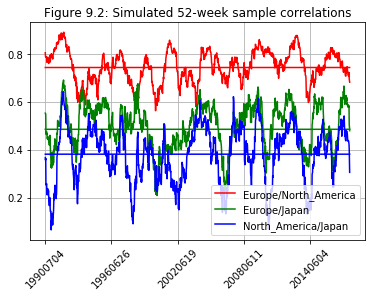

Standard Error =  0.14189319376693255


In [149]:
#Generate graph of either simulated or historical sample correlation from df_logs

def make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate):
#Generate a multivariate normal distribution using the data in df_logs
#compute sample correlations of size samplesize and graph them
#simulate: False, use historical data in df_logs
#          True, use simulated data in rtrial
    nobs=len(df_logs)
    nsecs=len(df_logs.columns)-1
    samplecorrs=[]
    corr_matrix=df_logs[df_logs.columns[1:]].corr()

    #Get sample correlations
    if simulate:
        for i in range(samplesize,nobs+1):
            samplecorrs.append(np.corrcoef(rtrial[i-samplesize:i].transpose()))
    else:
        for i in range(samplesize,nobs+1):
            samplecorrs.append(df_logs.iloc[i-samplesize:i] \
                    [df_logs.columns[1:]].corr().values)
        
    #plot sample correlations
    sccol=['r','g','b']
    ncorrs=nsecs*(nsecs-1)/2
    z=0
    #Go through each pair
    for j in range(nsecs-1):
        for k in range(j+1,nsecs):
            #form time series of sample correlation
            #for this pair of securities
            scs=[samplecorrs[i][j,k] for i in range(nobs-samplesize+1)]
            plt.plot(range(nobs-samplesize+1),scs, \
                     label=corr_matrix.columns[j]+'/' \
                     +corr_matrix.columns[k], \
                     color=sccol[z])
            #Show target correlation in same color
            line=[corr_matrix.iloc[j,k]]*(nobs-samplesize+1)
            plt.plot(range(nobs-samplesize+1),line,color=sccol[z])
            z+=1

    plt.legend()
    stride=int((nobs-periodicity+1)/(4*periodicity))*periodicity
    tix=[int(x) for x in \
         df_logs.sort_values(by="Date")["Date"][0:nobs-samplesize+1:stride]]
    plt.xticks(range(0,nobs-samplesize+1,stride),tix,rotation=45)
    plt.title(title_str+str(samplesize)+'-week sample correlations')
    plt.grid()
    plt.show();

#Generate a simulation    
#Show the Cholesky decomposition of the matrix
chol=np.linalg.cholesky(corr_matrix)
print('Cholesky:\n',chol)

#Generate random draws
nobs=len(df_logs)
nsecs=len(df_logs.columns)-1
strial=np.random.normal(0,1,size=[nobs,nsecs])
rtrial=np.matmul(chol,strial.T).T

samplesize=periodicity
title_str="Figure 9.2: Simulated "
simulate=True
import matplotlib.pyplot as plt
make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate)
print("Standard Error = ",np.tanh(1/np.sqrt(periodicity-3)))

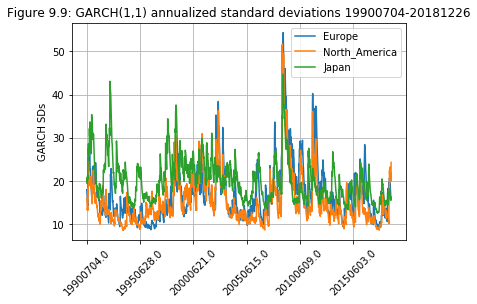

Europe a=0.1340 b=0.8388 c=0.00001873 AnnEquilibStd=0.1892
North_America a=0.1368 b=0.8273 c=0.00002033 AnnEquilibStd=0.1718
Japan a=0.0907 b=0.8696 c=0.00003368 AnnEquilibStd=0.2100


In [150]:
import scipy.stats as spst
from scipy.optimize import minimize_scalar

#CHEAT! - get overall mean and standard deviation vectors
#In practice, would need to do everything out of sample - 
#start with a learning sample, e.g.
overallmean=np.mean(df_logs)
overallstd=np.std(df_logs)
tickerlist=df_logs.columns[1:]   #skip the date column

#Get GARCH params for each ticker
gparams=[]
initparams=[.12,.85,.6]
stgs=[] #Save the running garch sigma's
for it,ticker in enumerate(tickerlist):
    #Note ORDER MATTERS: make sure values are in date order
    gparams.append(qf.Garch11Fit(initparams,df_logs.sort_values(by="Date")[ticker]))
    a,b,c=gparams[it]
    
    #Create time series of sigmas
    t=len(df_logs[ticker])
    minimal=10**(-20)
    stdgarch=np.zeros(t)
    stdgarch[0]=overallstd[ticker]
    
    #Compute GARCH(1,1) stddev's from data given parameters
    for i in range(1,t):
        #Note offset - i-1 observation of data
        #is used for i estimate of std deviation
        previous=stdgarch[i-1]**2
        var=c+b*previous+a*(df_logs.sort_values(by="Date")[ticker][i-1]-overallmean[ticker])**2
        stdgarch[i]=np.sqrt(var)

    #Save for later de-GARCHing
    stgs.append(stdgarch)
    
#Create plot
for it,ticker in enumerate(tickerlist):
    #Annualize
    stdgarch=100*np.sqrt(periodicity)*stgs[it]
    plt.plot(range(len(stdgarch)),stdgarch,label=ticker)

plt.grid()
plt.title('Figure 9.9: GARCH(1,1) annualized standard deviations '+str(min(df_logs["Date"]))[:8]+'-'+str(max(df_logs["Date"]))[:8])
plt.ylabel('GARCH SDs')
plt.legend()
stride=5*periodicity
plt.xticks(range(0,len(df_logs),stride),df_logs.sort_values(by="Date")["Date"][0:len(df_logs)-1:stride],rotation=45)
plt.show()

for it,ticker in enumerate(tickerlist):
    print(ticker,'a=%1.4f' % gparams[it][0], \
               'b=%1.4f' % gparams[it][1], \
               'c=%1.8f' % gparams[it][2], \
               'AnnEquilibStd=%1.4f' % \
               np.sqrt(periodicity*gparams[it][2]/ \
                       (1-gparams[it][0]-gparams[it][1])))

In [151]:
#Display before and after deGARCHing statistics

#Demeaned, DeGARCHed series go in dfeps
dfeps=df_logs.sort_values(by="Date").copy()
for it,ticker in enumerate(tickerlist):
    dfeps[ticker]-=overallmean[ticker]
    for i in range(len(dfeps)):
        dfeps[ticker].iloc[i]/=stgs[it][i]
    print(ticker)
    print('    DeGARCHed Mean:',np.mean(dfeps[ticker]))
    
    print('    Raw annualized Std Dev:',np.sqrt(periodicity)*overallstd[ticker])
    print('    DeGARCHed Std Dev:',np.std(dfeps[ticker]))
    
    print('    Raw excess kurtosis:',spst.kurtosis(df_logs[ticker]))
    print('    DeGARCHed Excess Kurtosis:',spst.kurtosis(dfeps[ticker]))

Europe
    DeGARCHed Mean: 0.003013227378523725
    Raw annualized Std Dev: 0.18027735742966103
    DeGARCHed Std Dev: 1.0015373044444003
    Raw excess kurtosis: 3.1434916128188046
    DeGARCHed Excess Kurtosis: 1.3434356913721537
North_America
    DeGARCHed Mean: -0.010962866253489308
    Raw annualized Std Dev: 0.1616503039927366
    DeGARCHed Std Dev: 1.0007433513429356
    Raw excess kurtosis: 4.800106894656275
    DeGARCHed Excess Kurtosis: 2.4316348331338693
Japan
    DeGARCHed Mean: -0.009530525868923714
    Raw annualized Std Dev: 0.20690123223081452
    DeGARCHed Std Dev: 1.001699588852838
    Raw excess kurtosis: 1.9902634917771689
    DeGARCHed Excess Kurtosis: 1.6815530510087102


Optimal lambda: 0.01232385156271316
Optimal objective function: 3052.44316383628
Half-life (years): 1.0749437136839535


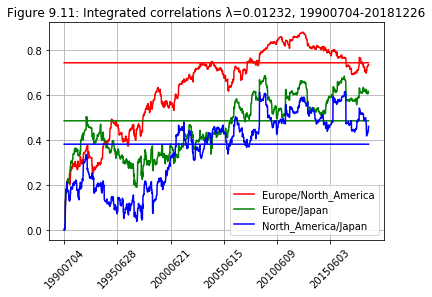

In [152]:
#Compute integrated correlations

InData=np.array(dfeps[tickerlist])

def IntegratedCorrObj(s):
    #Compute time series of quasi-correlation
    #matrices from InData using integrated parameter
    #xlam=exp(s)/(1+exp(s)); note this format removes
    #the need to enforce bounds of xlam being between
    #0 and 1. This is applied to formula 9.44.
    #Standardize Q's and apply formula 9.49.
    #Returns scalar 9.49
    xlam=np.exp(s)
    xlam/=1+xlam
    obj9p39=0.
    previousq=np.identity(len(InData[0]))
    #Form new shock matrix
    for i in range(len(InData)):
        #standardize previous q matrix and compute contribution to objective function
        stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
        previousr=np.matmul(stdmtrx,np.matmul(previousq,stdmtrx))
        #objective function
        obj9p39+=np.log(np.linalg.det(previousr))
        shockvec=np.array(InData[i])
        vec1=np.matmul(shockvec,np.linalg.inv(previousr))
        #This makes obj9p39 into a 1,1 matrix
        obj9p39+=np.matmul(vec1,shockvec)
              
        #Update q matrix
        shockvec=np.mat(shockvec)
        shockmat=np.matmul(shockvec.T,shockvec)
        previousq=xlam*shockmat+(1-xlam)*previousq
    return(obj9p39[0,0])
#Done with IntegratedCorrObj

result=minimize_scalar(IntegratedCorrObj)

xlamopt=np.exp(result.x)
xlamopt/=1+xlamopt
print('Optimal lambda:',xlamopt)
print('Optimal objective function:', result.fun)
if xlamopt>=1 or xlamopt==0:
    halflife=0
else:
    halflife=-np.log(2)/np.log(1-xlamopt)
print('Half-life (years):',halflife/periodicity)

#Plot integrated correlations
previousq=np.identity(len(InData[0]))
rmatrices=[]
for i in range(len(InData)):
    stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
    rmatrices.append(np.matmul(stdmtrx,np.matmul(previousq,stdmtrx)))
    shockvec=np.mat(np.array(InData[i]))
    #Update q matrix
    shockmat=np.matmul(shockvec.T,shockvec)
    previousq=xlamopt*shockmat+(1-xlamopt)*previousq

iccol=['r','g','b']
z=0
for it in range(len(tickerlist)-1):
    for jt in range(it+1,len(tickerlist)):
        y=[rmatrices[i][it,jt] for i in range(len(InData))]
        plt.plot(range(len(InData)),y, \
            label=tickerlist[it]+'/'+tickerlist[jt], \
            color=iccol[z])
        
        #Show target correlation in same color
        line=[corr_matrix.iloc[it,jt]]*(len(InData))
        plt.plot(range(len(InData)),line,color=iccol[z])
        z+=1
plt.grid()
xtitle='Figure 9.11: Integrated correlations λ=%1.5f' % xlamopt
xtitle+=', '+str(min(df_logs["Date"]))[:8]+'-'+str(max(df_logs["Date"]))[:8]
plt.title(xtitle)
stride=5*periodicity
tix=[int(x) for x in df_logs.sort_values(by="Date")["Date"][0:len(df_logs)-1:stride]]
plt.xticks(range(0,len(df_logs),stride),tix,rotation=45)
plt.legend()
plt.show()

Optimal alpha, beta: 0.012369456452232079 0.9824529585007461
Optimal objective function: 3035.926147893845
Half-life (years): 1.0709558340959726


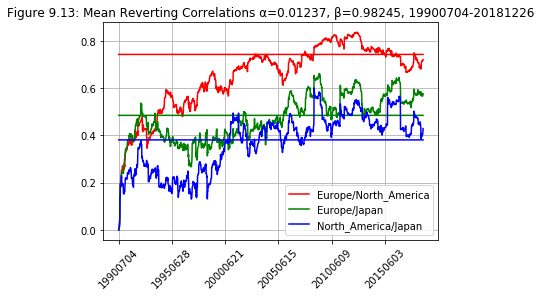

In [153]:
def MeanRevCorrObj(params):
    #Compute time series of quasi-correlation
    #matrices from InData using mean reverting
    #formula 9.45. Standardize them and apply
    #formula 9.49. Returns scalar 9.49
    
    #Extract parameters
    alpha,beta=params
    #Enforce bounds
    if alpha<0 or beta<0:
        return(10**20)
    elif (alpha+beta)>.999:
        return(10**20)
    
    obj9p39=0
    
    #Initial omega is obtained through correlation targeting
    Rlong=np.corrcoef(InData.T)
    previousq=np.identity(len(InData[0]))
    
    #Form new shock matrix
    for i in range(len(InData)):
        #standardize previous q matrix and compute contribution to objective function
        stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
        previousr=np.matmul(stdmtrx,np.matmul(previousq,stdmtrx))
        #objective function
        obj9p39+=np.log(np.linalg.det(previousr))
        shockvec=np.array(InData[i])
        vec1=np.matmul(shockvec,np.linalg.inv(previousr))
        #This makes obj9p39 into a 1,1 matrix
        obj9p39+=np.matmul(vec1,shockvec)
              
        #Update q matrix
        shockvec=np.mat(shockvec)
        shockmat=np.matmul(shockvec.T,shockvec)
        previousq=(1-alpha-beta)*Rlong+alpha*shockmat+beta*previousq
    return(obj9p39[0,0])
#Done with MeanRevCorrObj

import scipy.optimize as scpo
#alpha and beta positive
corr_bounds = scpo.Bounds([0,0],[np.inf,np.inf])
#Sum of alpha and beta is less than 1
corr_linear_constraint = scpo.LinearConstraint([[1, 1]],[0],[.999])

initparams=[.02,.93]

results = scpo.minimize(MeanRevCorrObj, \
        initparams, \
        method='trust-constr', \
        jac='2-point', \
        hess=scpo.SR1(), \
        bounds=corr_bounds, \
        constraints=corr_linear_constraint)

alpha,beta=results.x
print('Optimal alpha, beta:',alpha,beta)
print('Optimal objective function:',results.fun)
halflife=-np.log(2)/np.log(1-alpha)
print('Half-life (years):',halflife/periodicity)

#Plot mean reverting correlations
previousq=np.identity(len(InData[0]))
Rlong=np.corrcoef(InData.T)
rmatrices=[]
for i in range(len(InData)):
    stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
    rmatrices.append(np.matmul(stdmtrx,np.matmul(previousq,stdmtrx)))
    shockvec=np.mat(np.array(InData[i]))
    #Update q matrix
    shockmat=np.matmul(shockvec.T,shockvec)
    previousq=(1-alpha-beta)*Rlong+alpha*shockmat+beta*previousq

iccol=['r','g','b']
z=0
for it in range(len(tickerlist)-1):
    for jt in range(it+1,len(tickerlist)):
        y=[rmatrices[i][it,jt] for i in range(len(InData))]
        plt.plot(range(len(dfeps)),y, \
            label=tickerlist[it]+'/'+tickerlist[jt],color=iccol[z])
        #Show target correlation in same color
        line=[corr_matrix.iloc[it,jt]]*(len(InData))
        plt.plot(range(len(InData)),line,color=iccol[z])
        z+=1
plt.grid()
xtitle='Figure 9.13: Mean Reverting Correlations α=%1.5f' % alpha
xtitle+=', β=%1.5f' % beta
xtitle+=', '+str(min(df_logs["Date"]))[:8]+'-'+str(max(df_logs["Date"]))[:8]
plt.title(xtitle)
stride=5*periodicity
tix=[int(x) for x in \
     df_logs.sort_values(by="Date")["Date"][0:len(df_logs)-1:stride]]
plt.xticks(range(0,len(df_logs),stride),tix,rotation=45)
plt.legend()
plt.show();

In [154]:
#MacGyver method - pairwise integrated
minimal=10**(-20)
alpha_list=[]
beta_list=[]
for it in range(len(tickerlist)-1):
    tick1=tickerlist[it]
    for jt in range(it+1,len(tickerlist)):
        tick2=tickerlist[jt]
        InData=np.array(dfeps[[tick1,tick2]])
        
        # initial alpha and beta
        initparams=[.02,.93]
        # alpha and beta positive
        corr_bounds = scpo.Bounds([0,0],[np.inf,np.inf])
        #Sum of alpha and beta is less than 1
        corr_linear_constraint = scpo.LinearConstraint([[1, 1]],[0],[.999])
        #Optimize result
        results = scpo.minimize(MeanRevCorrObj,initparams,method='trust-constr',jac='2-point',hess=scpo.SR1(),bounds=corr_bounds, constraints=corr_linear_constraint)
        alpha,beta=results.x
        alpha_opt=np.exp(alpha)/(1+np.exp(alpha))
        beta_opt=np.exp(beta)/(1+np.exp(beta))
        
        print(tick1,tick2)
        print('Optimal alpha, beta:',alpha,beta)
        print('Optimal objective function:',results.fun)
        halflife=-np.log(2)/np.log(1-alpha)
        print('    Half-life (years):',halflife/periodicity)
        alpha_list.append(alpha_opt)
        beta_list.append(beta_opt)

print('\nMedian MacGyver alpha:',np.median(alpha_list))
print('\nMedian MacGyver beta:',np.median(beta_list))

Europe North_America
Optimal alpha, beta: 0.03858196271941999 0.9520514926540073
Optimal objective function: 1946.2412342351934
    Half-life (years): 0.33878326309934675
Europe Japan
Optimal alpha, beta: 0.010105959308414318 0.986734093177112
Optimal objective function: 2569.412290500759
    Half-life (years): 1.312323161984117
North_America Japan
Optimal alpha, beta: 0.005267463500619226 0.9929314154798314
Optimal objective function: 2718.611215776202
    Half-life (years): 2.5239122347125824

Median MacGyver alpha: 0.5025264683247023

Median MacGyver beta: 0.7284423621802094


### We see that using MacGyver method, the median half-life is 1.312323161984117. This is very similar to the half-life found from the mean-reverting model applied to the 3x3 quasi-correlation matrix (1.0709558340959726 years)